In [1]:
from typing import Optional
import argparse
import os
import sys

import torch
import matplotlib.pyplot as plt     # type: ignore

import utilities
import model
import optimize
import pandas as pd

from utils import default_paths

import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

info_fn = os.path.join(default_paths.stim_root, 'Indep_set_info.csv')
print('\nloading image info from %s\n'%info_fn)
info_df = pd.read_csv(info_fn, index_col=0)


cuda

loading image info from /user_data/mmhender/nsd/stimuli/Indep_set_info.csv



In [3]:
fn_info = os.path.join(os.getcwd(),'vgg19_rfs_info.npy')
rfs_info = np.load(fn_info, allow_pickle=True).item()    

In [4]:
rfs_info.keys()

dict_keys(['pixel_centers', 'layer_unit_centers', 'layer_names_use', 'layer_inds'])

In [5]:
pixel_centers = rfs_info['pixel_centers']
layer_unit_centers = rfs_info['layer_unit_centers']
layer_names = rfs_info['layer_names_use']
layer_inds = rfs_info['layer_inds']
n_layers = len(layer_names)
n_pix = np.max(pixel_centers)+1

In [6]:
rfs_each_layer = []
for ll, layer in enumerate(['Conv1','MaxPool1','MaxPool2','MaxPool3','MaxPool4']):
    fn_rfs = os.path.join(os.getcwd(),'vgg19_unit_rfs_%s.npy'%layer)
    rfs = np.load(fn_rfs)
    rfs_each_layer.append(rfs)
    

In [7]:
n_grid_eachside=4;
overlap_each_layer = []
for ll in range(n_layers):
    
    fn = os.path.join(os.getcwd(),'vgg19_gridoverlap_%dx%d_%s.npy'%(n_grid_eachside, \
                                                                    n_grid_eachside, layer_names[ll]))
    print(fn)
    overlap = np.load(fn)
    overlap_each_layer.append(overlap)

/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_4x4_Conv1.npy
/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_4x4_MaxPool1.npy
/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_4x4_MaxPool2.npy
/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_4x4_MaxPool3.npy
/user_data/mmhender/toolboxes/texture-synthesis-pytorch/vgg19_gridoverlap_4x4_MaxPool4.npy


In [95]:
class a():
    def __init__(self, n_ims_do=10, n_steps=10, debug=0):
        self.n_ims_do = n_ims_do
        self.n_steps = n_steps
        self.debug = debug
        

In [96]:
args = a()

In [97]:
ii=0;

print('\nim %d of %d'%(ii, args.n_ims_do))
        
target_image_filename = info_df['filename_raw'].iloc[ii]
print('processing target image %s'%target_image_filename)
sys.stdout.flush()

cocoid = target_image_filename.split('/')[-1].split('.')[0]

out_dir = os.path.join('/user_data/mmhender/stimuli/texture_synth_images', 'coco_%s'%cocoid)
print('will save images to %s'%out_dir)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

root = os.getcwd()
model_path = os.path.join(root, 'models','VGG19_normalized_avg_pool_pytorch')

args.lr = 1.0
args.max_iter = 20
args.checkpoint_every = 1
if args.debug:
    args.n_steps = 1
args.rndseed = None

# load model & data
target_image = utilities.preprocess_image(
    utilities.load_image(target_image_filename)
)



im 0 of 10
processing target image /lab_data/tarrlab/common/datasets/COCO/train2017/000000326021.jpg
will save images to /user_data/mmhender/stimuli/texture_synth_images/coco_000000326021


In [118]:
important_layers = ['relu1_1', 'pool1','pool2','pool3','pool4']

layers_match = important_layers

net = Model(model_path, device, target_image, important_layers=layers_match, 
                 spatial_weights_list = overlap_each_layer)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


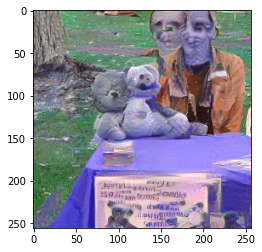

In [116]:
plt.figure()
plt.imshow(result[0,:,:,:].moveaxis([0],[2]).detach().cpu().numpy()/255+0.5)

In [ ]:
optimizer

In [119]:
# synthesize
# optimizer = optimize.Optimizer(net, args)
# result = optimizer.optimize()

computing spatially weighted gram matrix
torch.Size([64, 65536]) torch.Size([65536])
tensor([1., 1., 1., 1.], device='cuda:0')
0 0 tensor(4487567., device='cuda:0', grad_fn=<MulBackward0>)
computing spatially weighted gram matrix
torch.Size([64, 65536]) torch.Size([65536])
tensor([0., 0., 0., 0.], device='cuda:0')
1 1 tensor(5287517.5000, device='cuda:0', grad_fn=<MulBackward0>)
computing spatially weighted gram matrix
torch.Size([64, 65536]) torch.Size([65536])
tensor([0., 0., 0., 0.], device='cuda:0')
2 2 tensor(7466566., device='cuda:0', grad_fn=<MulBackward0>)
computing spatially weighted gram matrix
torch.Size([64, 65536]) torch.Size([65536])
tensor([0., 0., 0., 0.], device='cuda:0')
3 3 tensor(5811664.5000, device='cuda:0', grad_fn=<MulBackward0>)
computing spatially weighted gram matrix
torch.Size([64, 65536]) torch.Size([65536])
tensor([0., 0., 0., 0.], device='cuda:0')
4 4 tensor(6281501.5000, device='cuda:0', grad_fn=<MulBackward0>)
computing spatially weighted gram matrix
to

KeyboardInterrupt: 

In [112]:
from typing import List, Tuple

import torch

import utilities


def gram_matrix_spatweighted(activations: torch.Tensor, spatial_weights: torch.Tensor = None) -> torch.Tensor:
    b, n, x, y = activations.size()
    # print((b,n,x,y))
    activation_matrix = activations.view(b * n, x * y)
    
    print('computing spatially weighted gram matrix')
    print(activation_matrix.shape, spatial_weights.shape)
    print(spatial_weights[0:4])
    activation_matrix_weighted = activation_matrix * torch.sqrt(spatial_weights[None,:])
    
    G = torch.mm(activation_matrix_weighted, activation_matrix_weighted.t())    # gram product
    return G.div(b * n * x * y)     # normalization


class Model:
    def __init__(
        self, path: str, device: torch.device, target_image: torch.Tensor,
        layer_weights: List[float] = [1e09, 1e09, 1e09, 1e09, 1e09],
        important_layers: List[str] = [
            'relu1_1', 'pool1', 'pool2', 'pool3', 'pool4'
        ],
        spatial_weights_list: List[torch.Tensor] = None,
    ):
        self.net = utilities.load_model(path).to(device).eval()
        self.device = device
        self.target_image = target_image.to(device)
        self.layer_weights = layer_weights
        self.important_layers = important_layers
        # print(self.important_layers)
        
        self.spatial_weights_list = [torch.Tensor(sw).to(self.device) for sw in spatial_weights_list]
        if self.spatial_weights_list is not None:
            self.n_total_grid = self.spatial_weights_list[0].shape[0]
            assert(len(self.spatial_weights_list)==len(self.important_layers))
            
        # extract Gram matrices of the target image
        
        gram_hook = GramHook(self.spatial_weights_list)
        gram_hook_handles = []
        
        for name, layer in self.net.named_children():
            if name in self.important_layers:
               
                handle = layer.register_forward_hook(gram_hook)
                gram_hook_handles.append(handle)
            
        self.net(self.target_image)

        # print('gram matrices:')
        # print(len(gram_hook.gram_matrices), [gm.shape for gm in gram_hook.gram_matrices])
        # register Gram loss hook
        self.gram_loss_hook = GramLossHook(
            gram_hook.gram_matrices, self.layer_weights, \
            self.important_layers, self.spatial_weights_list,
        )
        # print('sizes of gram matrices')
        # for ii, mat in enumerate(gram_hook.gram_matrices):
        #     print(ii, mat.shape)
        for handle in gram_hook_handles:    # Gram hook is not needed anymore
            handle.remove()

        for name, layer in self.net.named_children():
            if name in self.important_layers:
                # print('adding loss hook for %s'%name)
                handle = layer.register_forward_hook(self.gram_loss_hook)

        # print([name for [name, l] in self.net.named_children()])
        # remove unnecessary layers
        i = 0
        for name, layer in self.net.named_children():
            if name == important_layers[-1]:
                break
            i += 1
        self.net = self.net[:(i + 1)]
        # print([name for [name, l] in self.net.named_children()])
        
    def __call__(self, image: torch.Tensor) -> torch.Tensor:
        self.gram_loss_hook.clear()

        return self.net(image)

    def get_loss(self) -> torch.Tensor:
        # return sum(self.gram_loss_hook.losses)
        return torch.stack(self.gram_loss_hook.losses, dim=0).sum(dim=0)

    
class GramHook:
    def __init__(self, 
                 spatial_weights_list: List[torch.Tensor]):
        self.gram_matrices = []
        self.spatial_weights_list = spatial_weights_list
        self.layer_counter = -1;
        
    def __call__(
        self, layer: torch.nn.Module, layer_in: Tuple[torch.Tensor],
        layer_out: torch.Tensor
    ):
        self.layer_counter+=1
        ll = self.layer_counter
        n_grid_total = self.spatial_weights_list[0].shape[0]
        for gg in range(n_grid_total):
            spatial_weights = self.spatial_weights_list[ll][gg,:]
            # print('size of spatial weights:')
            # print(spatial_weights.shape)
            gram_matrix = gram_matrix_spatweighted(layer_out.detach(), spatial_weights)
            # print('size of gram matrix:')
            # print(gram_matrix.shape)
            self.gram_matrices.append(gram_matrix)

class GramLossHook:
    def __init__(
        self, target_gram_matrices: List[torch.Tensor],
        layer_weights: List[float], layer_names: List[str],
        spatial_weights_list: List[torch.Tensor],
    ):
        self.target_gram_matrices = target_gram_matrices
        self.layer_weights = [
            weight * (1.0 / 4.0) for weight in layer_weights
        ]
        self.layer_names = layer_names
        self.losses: List[torch.Tensor] = []
        self.spatial_weights_list = spatial_weights_list
        self.layer_counter = -1;
        
    def __call__(
        self, layer: torch.nn.Module, layer_in: Tuple[torch.Tensor],
        layer_out: torch.Tensor
    ):
        self.layer_counter+=1
        ll = self.layer_counter
        # print('layer_counter = %d'%self.layer_counter)
        assert ll < len(self.layer_weights)
        assert ll < len(self.target_gram_matrices)
        assert not torch.isnan(layer_out).any()

        n_grid_total = self.spatial_weights_list[0].shape[0]
        for gg in range(n_grid_total):
            # print('len of layer_names: %d'%len(self.layer_names))
            
            tt = ll * n_grid_total + gg
            # print(ll, gg, tt)
            opt_gram_matrix = gram_matrix_spatweighted(layer_out, 
                                                       self.spatial_weights_list[ll][gg,:])
            
            # print(opt_gram_matrix.shape)
            # print(self.target_gram_matrices[tt].shape)
            loss = self.layer_weights[ll] * (
                (opt_gram_matrix - self.target_gram_matrices[tt])**2
            ).sum()
            print(tt, len(self.losses), loss)
            self.losses.append(loss)

    def clear(self):
        self.losses = []
        self.layer_counter=-1